## `Oligopool Calculator` in Action!

**Author** Ayaan Hossain

**Updated** Sepetember 30, 2024

This `jupyter` notebook will demonstrate the usage of `Oligopool Calculator` and describe how to use its many functions.

### Table of Contents

* [Notebook Setup](#Notebook-Setup)

* [What is Oligopool Calculator?](#What-is-Oligopool-Calculator?)

* [Design Mode Walthrough - An oligopool of 100K ribozyme variants](#Design-Mode-Walkthrough---An-oligopool-of-100K-ribozyme-variants)
    * [Simulate the problem](#Simulate-the-problem)
    * [Review constraints and formulate gameplan](#Review-constraints-and-formulate-gameplan)
    * [Primer design review](#Primer-design-review)
    * [Storing the plasmid background](#Storing-the-plasmid-background)
    * [Designing the three primers](#Designing-the-three-primers)

### Notebook Setup

If you [installed](https://github.com/ayaanhossain/oligopool#Installation) `Oligopool Calculator` successfully, you have everything you need to follow along.

Let's first import `oligopool`.

In [1]:
import oligopool as op

Hopefully, the import worked without throwing up any errors! If you face issues importing, please [open an issue](https://github.com/ayaanhossain/oligopool/issues).

Let us also import `numpy` to do some math, and use `pandas` as our central data container.

In [2]:
import numpy  as np
import pandas as pd

We will also need `matplotlib`/`seaborn` for plotting.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

Lastly, we will need to use some operating system functions to manipulate files and directories.

In [4]:
import os

We're all set.

### What is Oligopool Calculator?

Oligonucleotide pools (oligopools) have revolutionized synthetic biology by enabling large-scale, cost-effective synthesis of hundreds of thousands of unique, short single-stranded DNA sequences through semiconductor-based technology, with major providers leading the market.

These oligopools facilitate the creation and study of various biological components, including de novo promoters, ribozymes, protein scaffolds, and CRISPR libraries. Massively parallel reporter assays (MPRAs) are utilized to clone and assess the functionality of these variants using high-throughput next-generation sequencing (NGS), which can generate billions of short reads per experiment.

Oligopool technology is shaping up to be a cornerstone of contemporary synthetic biology research.

Looking ahead, advancements are expected in the number and length of oligos, NGS throughput, and reductions in manufacturing costs. Successful projects would then require not only core functional variants but also essential components like primers for amplification, spacers for structural integrity, and barcodes for accurate quantification via NGS.

![Oligopool Calculator Workflow](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/workflow.svg)

`Oligopool Calculator` is a comprehensive tool for designing and analyzing large-scale oligonucleotide pools used in synthetic biology research.

In **(a)** `Design Mode`, the algorithms optimize various elements of the oligopool, including barcodes, primers, spacers, and degenerate motifs. It ensures that these components are maximally distinct, non-repetitive, and free from undesired sequences or structures. The tool also enables the splitting of long oligos into shorter fragments with optimized overlaps for downstream assembly.

The **(b)** `Analysis Mode` of the Oligopool Calculator facilitates the processing of next-generation sequencing (NGS) data derived from barcoded amplicons. This mode allows for efficient mapping and counting of variants and their associated barcodes, producing count matrices for quantitative assessment of variant functionality. Two types of counting operations are supported: Association counting for assessing synthesis accuracy, and Combinatorial counting for analyzing multiple barcode combinations from sequencing reads.

Overall `Oligopool Calculator` provides synthetic biologists with a unified platform for oligopool design and characterization, addressing the need for a standardized approach across different projects and labs. This tool eliminates the need for reinventing design scripts or using suboptimal strategies, making it particularly valuable for designing and analyzing pools containing millions of defined variants.

### Design Mode Walkthrough - An oligopool of 6K ribozyme variants

Suppose we want to design and test a library of 6,232 ribozyme variants based on the following architecture, which we characterized as part of our paper.

![Ribozyme Library Architecture](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/architecture.svg)

In the actual experiment, we designed them to be highly non-repetitive hammerhead ribozymes with a maximum shared repeat length of 16 bases using [`Non-Repetitive Parts Calculator`](https://github.com/ayaanhossain/nrpcalc), for simultaneous use as insulators in engineering large genetic system designs.

To characterize the activity of our ribozyme library in _E. coli_ we adopted a two-barcode strategy for designing the oligopool. Because ribozymes are self-cleaving, the two barcodes, BC1 and BC2, placed before and after the core variant would be separated after catalysis. This allowed us to count the ratio of their separation to quantify the efficiency of the ribozymes on a proportional scale (i.e., 0 to 100% cleavage efficiency) and normalize against wildtype ribozyme cleavage efficiencies.

#### Simulate the problem

For the purposes of demonstration, let us first generate a random library of 59-73 mers (designing exact ribozymes is beyond the scope here) and assume that the library will be cloned into a 5kb plasmid backbone for characterization, which we will also generate.

In [5]:
rng = np.random.default_rng(seed=42)

In [6]:
dna = ['A', 'T', 'G', 'C']

In [7]:
ribozymes = [''.join(rng.choice(dna, size=rng.integers(low=59, high=74))) for _ in range(6232)]

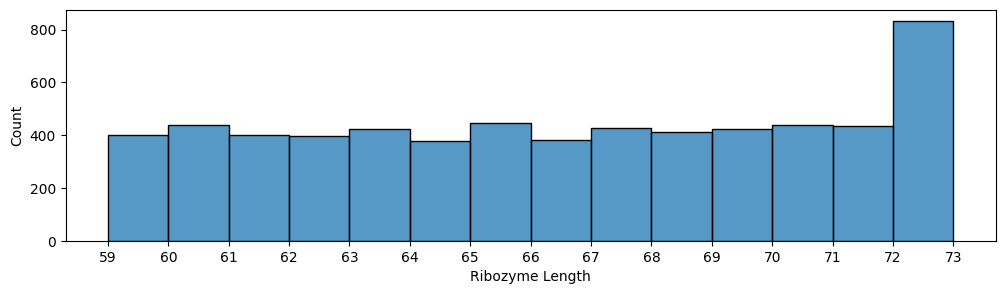

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
sns.histplot([len(x) for x in ribozymes], binwidth=1)
ax.set_xticks(np.arange(59,74))
ax.set_xlabel('Ribozyme Length')
plt.show()

In [9]:
len(ribozymes)

6232

In [10]:
plasmid = ''.join(rng.choice(dna) for _ in range(5000))

In [11]:
len(plasmid) # 5kbp long plasmid

5000

#### Review constraints and formulate gameplan

So, we have 6,232 simulated candidates, between 59 to 73bp in length and a plasmid of length 5kbp.

The design goal is straightforward. We have our simulated ribozyme library to start, and we know we want to use `EcoRI` and `AatII` as our restriction sites as part of the characterization process. What we can do now is use `Oligopool Calculator` to design the following.
* Three primers, each 20bp in length,
* The prefix and suffix barcodes each 11bp in length, and
* Variable length spacers ranging from 3 to 17bp to pad the oligos to 170bp.

As constraints, we aim to have the following.
* The primers should not have off-target binding within the library or to the backbone,
* Addition of primers, barcodes or spacers should not introduce `EcoRI` and `AatII` motifs elsewhere, and
* The barcodes should all have at least 3 mismatches separating each other.

Other realistic constraints, such as exclusion of all palindomic hexamers, or polymeric runs such as `'AAAAA'`, ..., `'CCCC'` may be included as they were in the original projects, but we will skip those for this demonstration. In reality, multiple constaints will depend on the design goals.

How do we begin? By asking `help` from `Oligopool Calculator`.

In [12]:
help(op)

Help on package oligopool:

NAME
    oligopool

DESCRIPTION
    oligopool v2024.09.29
    by ah

    Automated design and analysis of oligopool libraries.

    The various modules in Oligopool Calculator can be used
    interactively in a jupyter notebook, or be used to define
    scripts for design and analysis pipelines on the cloud.

    Oligopool Calculator offers two modes of operation
        -   Design Mode for designing oligopool library
        - Analysis Mode for analyzing oligopool datasets

    Design Mode workflow

        1. Initialize a pandas DataFrame with core library elements
            a. The DataFrame must contain a unique 'ID' column serving as primary key
            b. All other columns in the DataFrame must be DNA sequences or a - (dash)
        2. Next, define any optional background sequences via the background module
        3. Add necessary oligopool elements with constraints via design modules
        4. Optionally, split long oligos and pad them via asse

To begin, per the help, will need to use the `barcode`, `primer`, `motif` and `spacer` modules to add the library elements.

#### Primer design review

Generally, the primers for a library are the most constrained elements in the library because they have to be very specific to the library with minimal off-targeting. For oligopool libraries, it is recommended to design the primers first and get them out of the way. At any step in the design process if we get stuck, `Oligopool Calculator` will tell us what is preventing it from succeeding and we can relax or modify any constraints accordingly.

How do we design primers? Let's ask for help!

In [13]:
help(op.primer)

Help on function primer in module oligopool.primer:

primer(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, primer_sequence_constraint: str, primer_type: int, minimum_melting_temperature: float, maximum_melting_temperature: float, maximum_repeat_length: int, primer_column: str, output_file: str | None = None, paired_primer_column: str | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, background_directory: str | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Designs constrained primers with specified melting temperature and non-repetitiveness
    for all variants in the oligopool. Ensures compatibility with paired primers and minimizes
    dimer formation. Returns a DataFrame of designed primers, optionally saving to <output_file>
    in CSV format.

    Required Parameters:
        - input_data (str / pd.DataF

Two things should stand out here. First, the primer design involves consideration of background sequences to minimize off-target amplification, such as from the plasmid we set up. Second, primer design involves consideration of pairing information -- this implies primers need to be designed in pairs in a particular order. If we only had two primers (one forward and one reverse) the order would not matter. But in our problem, there are two forward primers (pink and orange) for both of which we have a single reverse primer (yellow).

Let us first solve the background problem.

#### Storing the plasmid background

`Oligopool Calculator` makes it easy to define a background for primer design via the `background` module.

In [14]:
help(op.background)

Help on function background in module oligopool.background:

background(input_data: list | str | pandas.core.frame.DataFrame, maximum_repeat_length: int, output_directory: str, verbose=True) -> dict
    The background function creates a k-mer database from a list or CSV file of background sequences.
    This database is used during primer design to ensure primers are non-repetitive to the background,
    minimizing off-target amplification. Non-repetitiveness is regulated by the maximum shared repeat
    length parameter. The generated database is saved in the specified <output_directory>.

    Required Parameters:
        - input_data (list / str / pd.DataFrame): background for primers; can be a CSV file or a DataFrame.
        - maximum_repeat_length (int): Max repeat length between primers and background (between 6 and 20).
        - output_directory (str): Directory to store the generated background k-mer database.
        - verbose (bool): If True, logs updates to stdout (default:

> **Note:** If you want to modify the background post-hoc, or want to define your background using a custom strategy, directly use the `vectorDB` module, which behaves like a dictionary. For details use `help(op.vectorDB)`. The `background` module just wraps around it and offers an one-time use simple interface to `vectorDB`.

In [15]:
background_directory = 'demo.oligopool.background'

In [16]:
# Remove the background if one exists already -- for demo
if os.path.exists(background_directory):
    op.vectorDB(background_directory, maxreplen=11, mode=1).drop()

In [17]:
background_stats = op.background(
    input_data=plasmid,
    maximum_repeat_length=10,
    output_directory=background_directory)


[Oligopool Calculator: Design Mode - Background]
                                                  
 Required Arguments
 Background      Data: 1 Unique Sequence(s)
    Maximum    Repeat: Up to 10 Base Pair(s) Background Repeats
     Output Directory: demo.oligopool.background                
                                                 
[Computing Background]
 Sequence 1: TGTGCCAACCGACTTCTGAA... Inserted
 Time Elapsed: 0.02 sec                       
                        
[Background Statistics]
 Background Status: Successful
      k-mer  Space: 2,097,152 Unique 11-mers
       Fill  Count:     4,973 Unique 11-mers (  0.24 %)
       Left  Count: 2,092,179 Unique 11-mers ( 99.76 %) 
 Time Elapsed: 0.03 sec                                 



In [18]:
background_stats

{'status': True,
 'basis': 'solved',
 'step': 1,
 'step_name': 'computing-background',
 'vars': {'kmer_space': 2097152, 'fill_count': 4973, 'left_count': 2092179},
 'warns': {}}

We've now stored the background, and are ready to design the three primers.

> **Note**: All `Oligopool Calculator` functions return a pipeline statistics dictionary recapitulating the steps performed in the function.

#### Designing the three primers

All `Design Mode` input and output is chained via a `pandas` `DataFrame` to facilitate piplined designs. Let us store the ribozyme candidates in a dataframe and start the design process.

In [19]:
init_df = pd.DataFrame({
    'ID': [f'ribozyme_{x+1:06d}' for x in range(len(ribozymes))],
    'EcoRI': 'GAATTC',
    'Variant':ribozymes,
    'AatII': 'GACGTC',
})

In [20]:
init_df.head(5)

,ID,EcoRI,Variant,AatII
0,ribozyme_000001,GAATTC,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GACGTC
1,ribozyme_000002,GAATTC,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GACGTC
2,ribozyme_000003,GAATTC,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GACGTC
3,ribozyme_000004,GAATTC,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GACGTC
4,ribozyme_000005,GAATTC,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GACGTC


The optimal solution here is to design the innermost (pink) forward primer first, and then design the reverse primer (yellow), followed by designing the outermost (orange) forward primer. This is allows all three primers to be compatible with each other.

In [21]:
# help(op.primer)

In [22]:
pink_primer_df, pink_primer_stats = op.primer(
    input_data=init_df,
    oligo_length_limit=170,                    # Must not exceed 170bp at any stage
    primer_sequence_constraint='N'*18 + 'WW',  # The last two bases must be weak
    primer_type=0,                             # This is a forward primer
    paired_primer_column=None,                 # No paired primer yet
    minimum_melting_temperature=53,            # Tm = 53°C at least
    maximum_melting_temperature=55,            # Tm = 55°C at most
    maximum_repeat_length=8,                  # No more than 14-mer repeats
    primer_column='PinkForward',               # Store designs in 'PinkForward' column
    left_context_column='Variant',             # Next to 'Variant' column
    right_context_column=None,                 # Before 'AatII' column
    excluded_motifs=['GAATTC', 'GACGTC'],      # Ensure EcoRI and AatII do not emerge as motifs
    background_directory=background_directory, # As setup before
    output_file=None,                          # In-memory return, no CSV written here
)


[Oligopool Calculator: Design Mode - Primer]
                                              
 Required Arguments
      Input Data       : DataFrame w/ 6,232 Record(s)
      Oligo Limit      : At most 170 Base Pair(s)     
     Primer Sequence   : A 20 Base Pair IUPAC Constraint
     Primer Type       : Forward Primer Design           
    Melting Temperature: 53 to 55 °C           
     Repeat Length     : Up to 8 Base Pair(s) Oligopool Repeats
     Primer Column     : Output in Column 'PinkForward'         
     Output File       : In-Memory DataFrame            
                                             
 Optional Arguments
     Paired Primer     : None Specified
       Left Context    : Input from Column 'Variant'
      Right Context    : None Specified              
   Excluded Motifs     : 2 Unique Motif(s)
 Background Database   : Contains 4,973 Unique 11-mers
                                                       
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base

Let us now design the two remaining primers in silent mode.

In [23]:
yellow_primer_df, _ = op.primer(
    input_data=pink_primer_df,                 # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='WW' + 'N'*18,  # Last two bases must be weak in reverse complement
    primer_type=1,                             # This is a reverse primer
    paired_primer_column='PinkForward',        # Yellow reverse primer paired with pink forward primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    primer_column='YellowReverse',             # Store designs in 'YellowReverse' column
    left_context_column='PinkForward',         # Next to 'PinkForward' column
    right_context_column='AatII',              # Before 'AatII' column
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    output_file=None,                          # In-memory return, no CSV written here
    verbose=False,
)

In [24]:
orange_primer_df, _ = op.primer(
    input_data=yellow_primer_df,               # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='N'*18 + 'WW',  # The last two bases must be weak
    primer_type=0,                             # This is a forward primer
    paired_primer_column='YellowReverse',      # Orange forward primer paired with yellow reverse primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    primer_column='OrangeForward',             # Store designs in 'OrangeForward' column
    left_context_column='EcoRI',               # Next to 'EcoRI' column
    right_context_column='Variant',            # Before 'AatII' column
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    output_file=None,                          # In-memory return, no CSV written here
    verbose=False,
)

In [25]:
orange_primer_df.head(5)

,EcoRI,OrangeForward,Variant,PinkForward,YellowReverse,AatII
ID,,,,,,
ribozyme_000001,GAATTC,CCCTCCATCGCTTCCTGTTT,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GTACCCCACCTATCCGCCTT,AAGTCGTCGGTAATCGGGGT,GACGTC
ribozyme_000002,GAATTC,CCCTCCATCGCTTCCTGTTT,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GTACCCCACCTATCCGCCTT,AAGTCGTCGGTAATCGGGGT,GACGTC
ribozyme_000003,GAATTC,CCCTCCATCGCTTCCTGTTT,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GTACCCCACCTATCCGCCTT,AAGTCGTCGGTAATCGGGGT,GACGTC
ribozyme_000004,GAATTC,CCCTCCATCGCTTCCTGTTT,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GTACCCCACCTATCCGCCTT,AAGTCGTCGGTAATCGGGGT,GACGTC
ribozyme_000005,GAATTC,CCCTCCATCGCTTCCTGTTT,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GTACCCCACCTATCCGCCTT,AAGTCGTCGGTAATCGGGGT,GACGTC


We are done with primers. Barcodes up next!